# Pulse Shape Discrimination (PSD) Utilising a 1D Convolutional Neural Network (CNN)
---

In [1]:
#import visualisation/essential operator libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

#visualisation settings
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 10

In [2]:
#importing the datasets
xtrain = np.load("x_train.npy")
ytrain = np.load("y_train.npy")
xtest = np.load("x_test.npy")
ytest = np.load("y_test.npy")
print(xtrain.shape,xtest.shape)

(12302, 1000) (3076, 1000)


# Understanding the Data
---

With the aim being to differentiate two types of signals, the Electron Scintillation (ES) from the Nuclear Scintillation (NS), it's worth exploring the data to understand its nature. Signals can vary widely in their characteristics, for example in terms of noise levels and various other distortions. It also can provide further insights for developing the CNN, for instance understanding the feasibility of its application to the context. 

From visualising some random samples from the training data, its clear that there is a noticeable distinction between ES and NS. NS is characterised by a trail of pulses that gradually reduce in amplitude, whereas ES tends to have more individual sharp pulses.

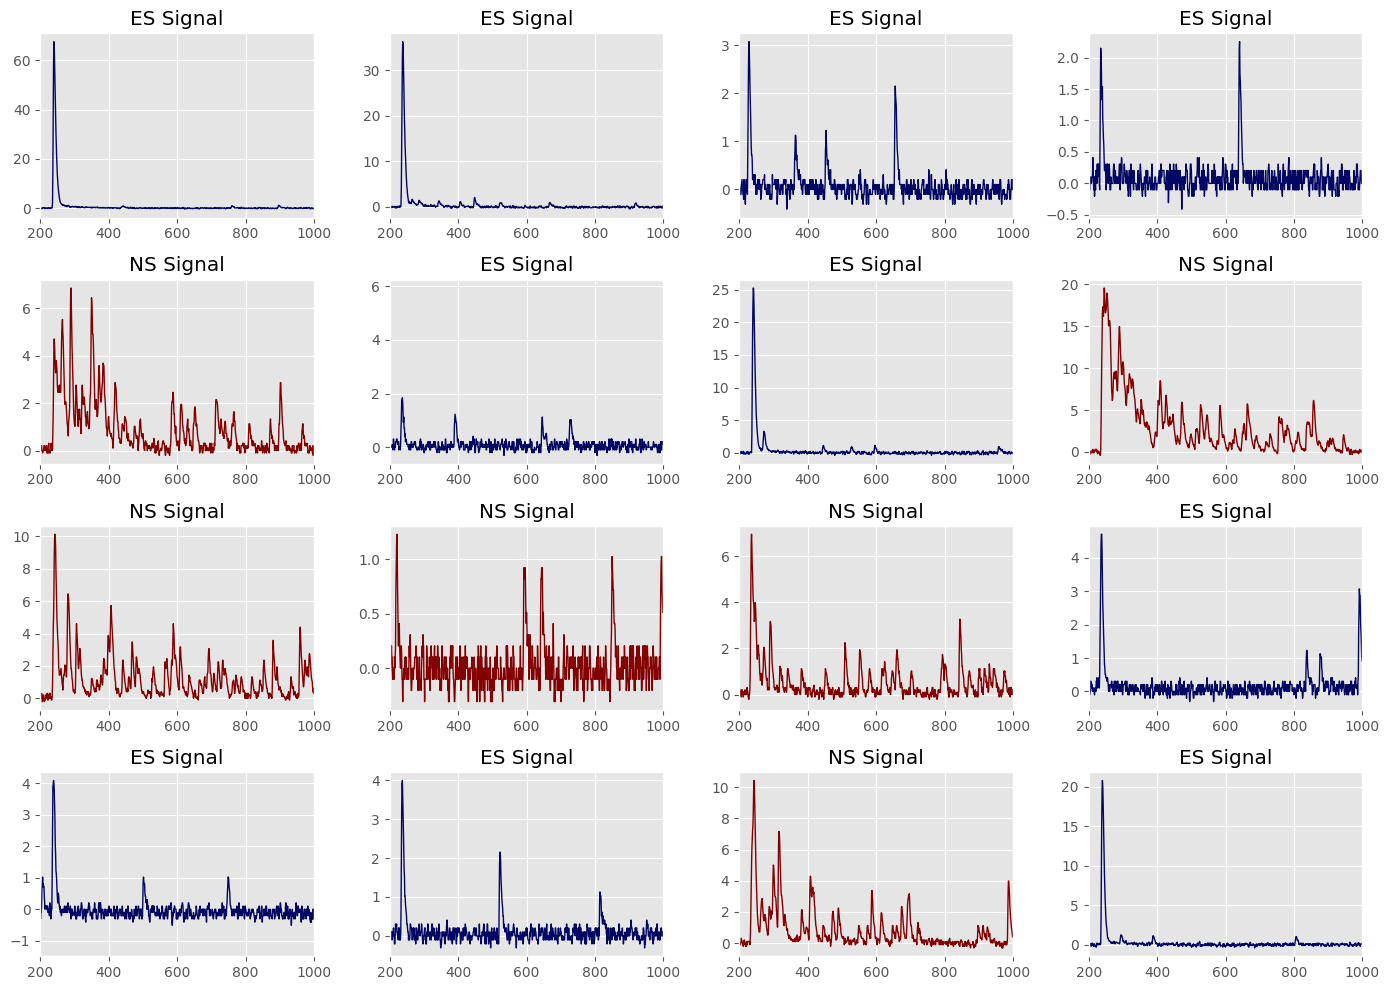

In [3]:
y_train = np.array(ytrain) #convert to np array

fig, ax = plt.subplots(4, 4, figsize=(14, 10)) #create 4x4 grid of subplots
ax = ax.flatten() #flatten for easy iterating

title_fontsize = 10 #set font size for titles

#loop to create subplots
for i in range(16):
    j = np.random.randint(0, len(xtrain)) #randomly select index to plot
    
    class_label = np.argmax(y_train[j]) #determine class label for selected index

    #set colour and title based on label
    if class_label == 0:
        title = "ES Signal"
        color = 'xkcd:darkblue'
    else: 
        title = "NS Signal"
        color = 'xkcd:dark red'

    ax[i].plot(xtrain[j], color=color, lw=1) #plot in selected subplot
    ax[i].set_title(title) #set title
    ax[i].set_xlim(200., 1000)  #set x-axis limits

fig.tight_layout() #adjust layout
plt.show() #display figure

Averaging and overlaying the signals separated by class has given further intuition into the varying signal characteristics. From the averaged signal it's clear that ES is characterised by a large pulse at the beginning, whereas NS has a less significant pulse but has continous pulses throughout the timeframe. From the overlay, this becomes more apparent. With there being significant "fuzz" throughout the time period, representing the fluctuations in signal. What also becomes apparent is that there are various ES signals with extreme peaks at the beginning.

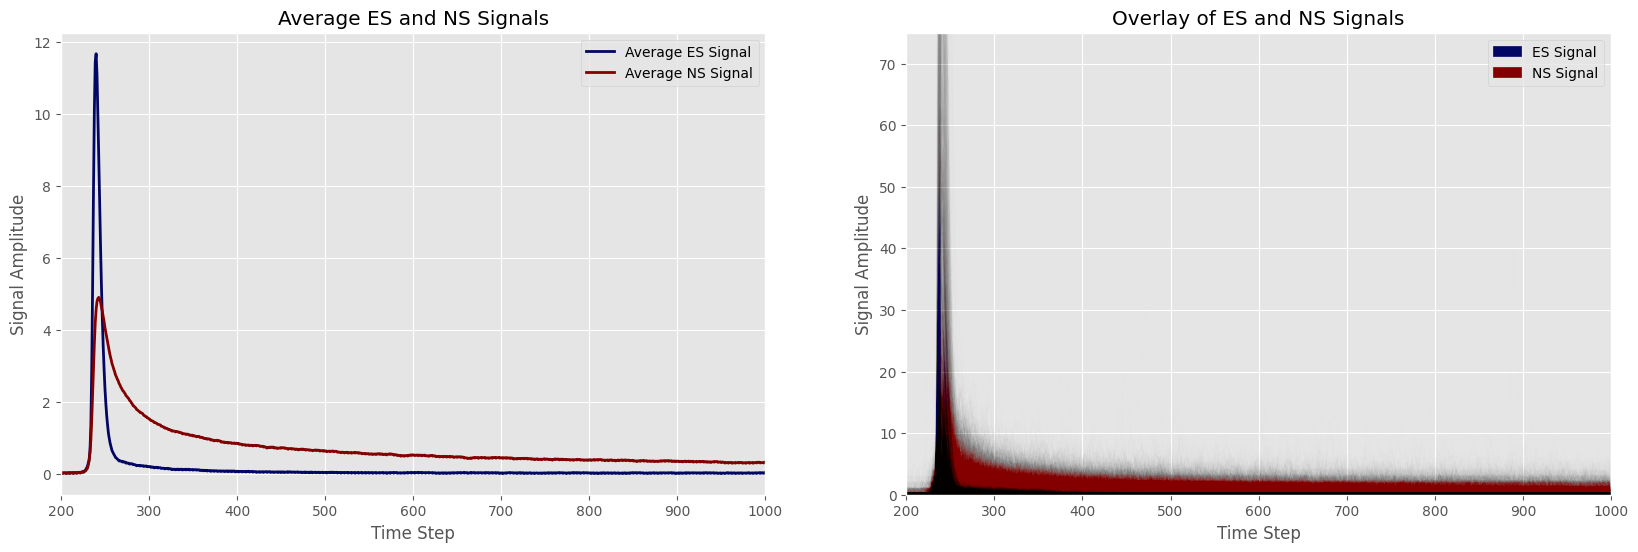

In [4]:
from matplotlib.patches import Patch

#calc average signals for each class
es_signals = xtrain[y_train.argmax(axis=1) == 0]
ns_signals = xtrain[y_train.argmax(axis=1) == 1]
average_es_signal = np.mean(es_signals, axis=0)
average_ns_signal = np.mean(ns_signals, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(20, 6)) #create subplots

#plot of average signals for each class
axes[0].plot(average_es_signal, color='xkcd:darkblue', lw=2, label='Average ES Signal')
axes[0].plot(average_ns_signal, color='xkcd:dark red', lw=2, label='Average NS Signal')
axes[0].set_title("Average ES and NS Signals")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Signal Amplitude")
axes[0].set_xlim(200., 1000)
axes[0].legend()

#create custom legend labels for 2nd subplot
es_patch = Patch(color='xkcd:darkblue', label='ES Signal')
ns_patch = Patch(color='xkcd:dark red', label='NS Signal')

#plotting all signals with transparency in the second subplot
alpha_level = 0.005
for signal in es_signals:
    axes[1].plot(signal, color='xkcd:darkblue', lw=1, alpha=alpha_level)
for signal in ns_signals:
    axes[1].plot(signal, color='xkcd:dark red', lw=1, alpha=alpha_level)
axes[1].set_title("Overlay of ES and NS Signals")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("Signal Amplitude")
axes[1].set_xlim(200., 1000)
axes[1].set_ylim(0,75)

#adding the custom legend to the second subplot
axes[1].legend(handles=[es_patch, ns_patch])

plt.show() #show plot

## Fast Fourier Transform (FFT)
---

Applying Fourier Transform is a common technique in time series analysis and signal processing. By converting from the time domain to the frequency domain, the frequency content of the signal can be analysed more clearly. This may aid in discriminating between signals, revealing hidden patterns that are not apparent in the time domain.

In [5]:
#apply FFT to each sample in xtrain and xtest
xtrain_fft = np.fft.fft(xtrain)
xtest_fft = np.fft.fft(xtest)

#compute magnitudes (absolute values)
xtrain_magnitude = np.abs(xtrain_fft)
xtest_magnitude = np.abs(xtest_fft)

#FFT is symmetric, so takes the first half for more intuitive visualisations
half_n = xtrain_magnitude.shape[1] // 2
xtrain_reduced = xtrain_magnitude[:, :half_n]
xtest_reduced = xtest_magnitude[:, :half_n]

#normalise the FFT output
xtrain_normalised = xtrain_reduced / np.max(xtrain_reduced, axis = 1, keepdims = True)
xtest_normalised = xtest_reduced / np.max(xtest_reduced, axis = 1, keepdims = True)

### Magnitude
---

Visualising the singals in the frequency domain, from first glance it seems that they are likely harder to distinguish in this domain. However it is possible that the magnitude has a unique relationship with the phase component that helps distinguish between signals effectively.

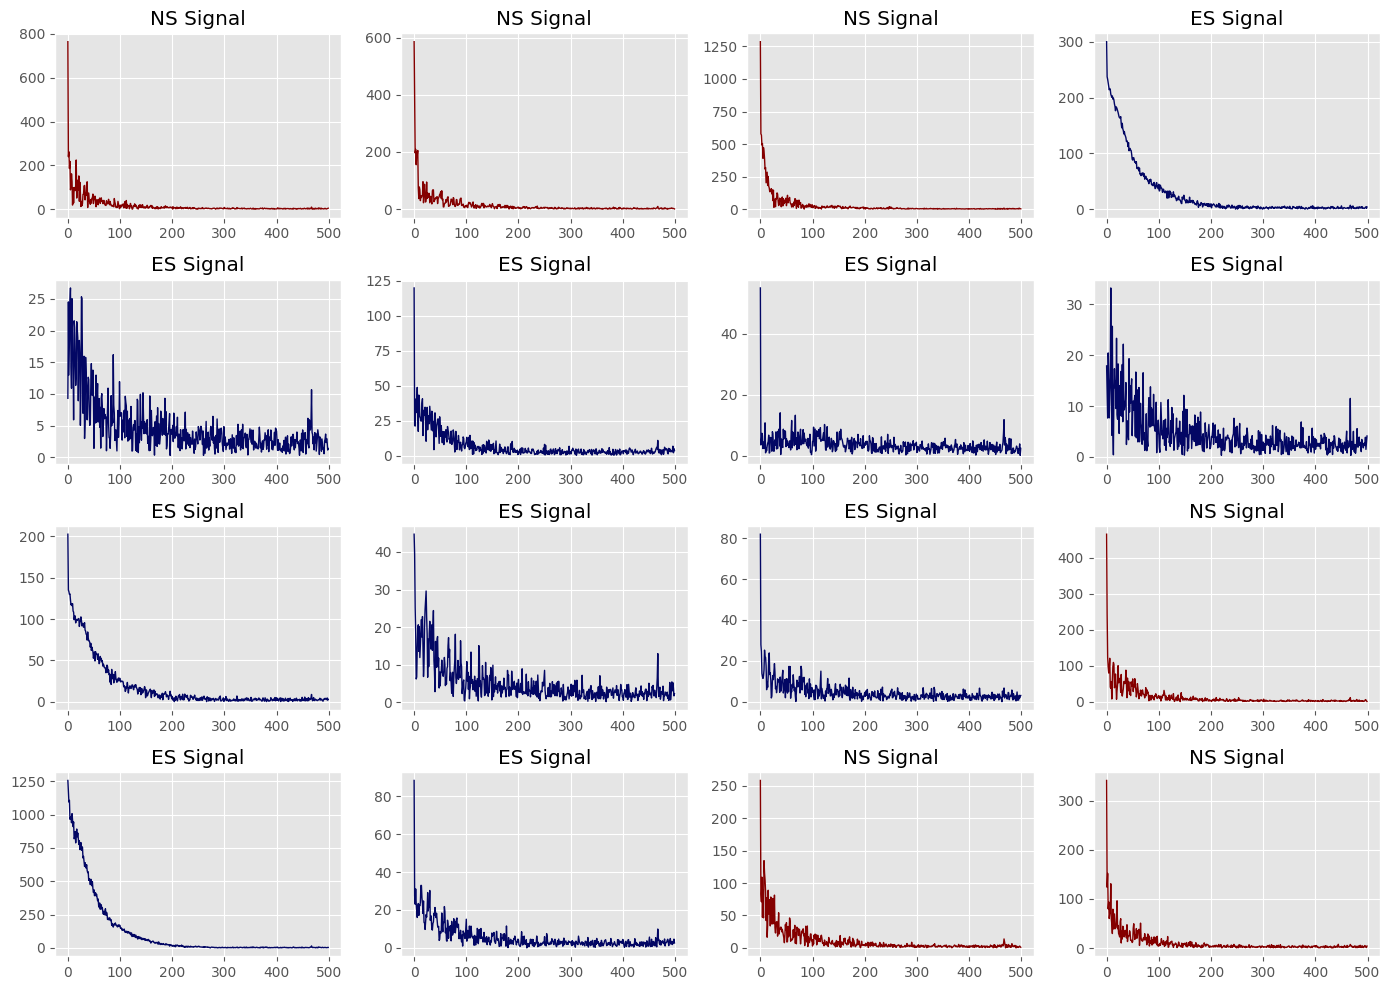

In [6]:
fig, ax = plt.subplots(4, 4, figsize=(14, 10)) #create 4x4 grid
ax = ax.flatten() #flatten array for easy iterating

#loop to create 16 subplots
for i in range(16):
    j = np.random.randint(0, len(xtrain_reduced)) #randomly choose a sample from training data
    
    #set title and colour based on class label
    class_label = np.argmax(y_train[j])
    if class_label == 0:
        title = "ES Signal"
        color = 'xkcd:darkblue'
    else:
        title = "NS Signal"
        color = 'xkcd:dark red'

    #plot the selected data
    ax[i].plot(xtrain_reduced[j], color=color, lw=1)
    ax[i].set_title(title)

fig.tight_layout() #adjust layout
plt.show() #display figure


### Phase
---

From visualising the phase spectrum alone, it's clear that this alone won't provide unique identifying information that can differeniate between the two classes. It would, of course, be ineffective in a 1D CNN for example; however when coupled with the magnitude to give both components of the signal, it could prove to be effective at discriminating signals in a 2D CNN.

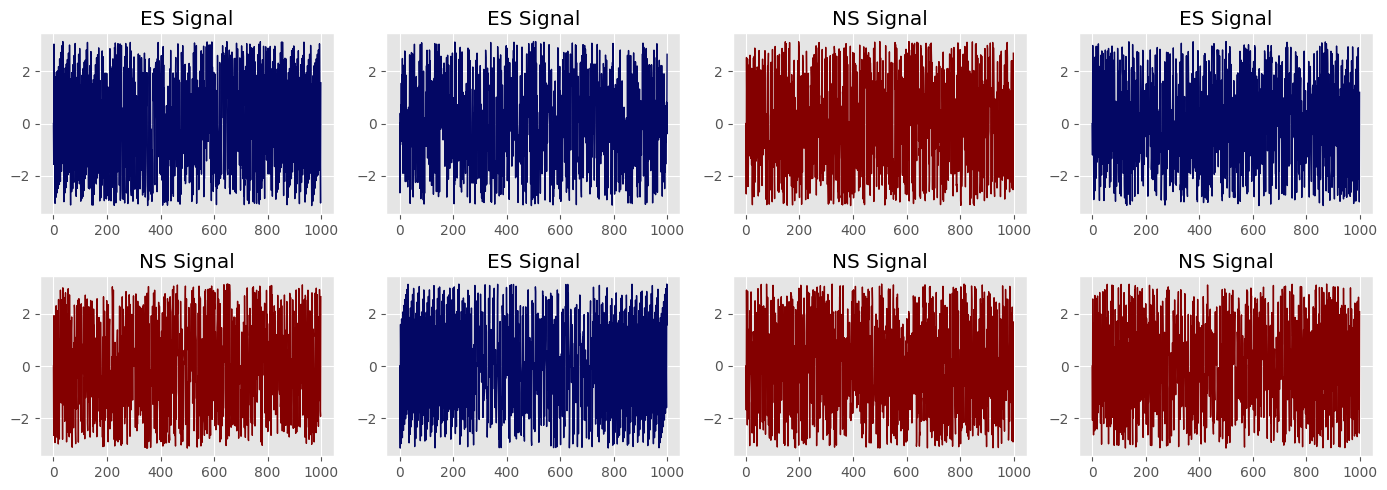

In [7]:
#compute phases
xtrain_phase = np.angle(xtrain_fft)
xtest_phase = np.angle(xtest_fft)

fig, ax = plt.subplots(2, 4, figsize=(14, 5)) #2x4 grid
ax = ax.flatten() #flatten axis

#loop to plot figures
for i in range(8):
    j = np.random.randint(0, len(xtrain_phase)) #randomly chooses a phase to plot
    
    #determine class and related title/colour
    class_label = np.argmax(y_train[j])
    if class_label == 0:
        title = "ES Signal"
        color = 'xkcd:darkblue'
    else:  
        title = "NS Signal"
        color = 'xkcd:dark red'

    #plot the phase
    ax[i].plot(xtrain_phase[j], color=color, lw=1)
    ax[i].set_title(title)

fig.tight_layout() #adjust layout
plt.show() #show figure

# Building an Initial Model
---

*** *Multiple models will be developed throughout the notebook. There will be detailed descriptions of the architectures/training parameters, however only initial observations whilst developing each. A deeper, comparative discussion is undertaken at the end of the notebook* ***

### Reshaping and Loading Data
---

The data needs some reshaping to make it compatible with the PyTorch CNN. This involves adding the number of channels.

Data loaders are also used for efficient data handling and easy batch processing among other benefits. A batch size of 256 is used, this is chosen as a reasonable trade-off between training speed, memory usage and model performance.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

#adds number of channels to make required input
mX_train = xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1]) 
mX_test = xtest.reshape(xtest.shape[0], 1, xtest.shape[1])

#load target data to tensors
ty_train = torch.Tensor(ytrain).long() 
ty_test = torch.Tensor(ytest).long()

#convert from one-hot encoding to binary
_, mty_train = torch.max(ty_train, 1) 
_, mty_test = torch.max(ty_test, 1) 


def load_data(mX_train, mX_test, mty_train, mty_test, batch_size = 256):
    """
    Loads and preprocesses the training and testing data for use in a PyTorch model.

    This function converts the input data into PyTorch tensors, wraps them into TensorDatasets,
    and then creates DataLoader objects for the training and testing datasets. The training
    DataLoader shuffles the data and can drop the last incomplete batch, if any.

    Parameters:
    mX_train (numpy.ndarray): The training data features.
    mX_test (numpy.ndarray): The testing data features.
    mty_train (torch.Tensor): The training data labels as a PyTorch Tensor.
    mty_test (torch.Tensor): The testing data labels as a PyTorch Tensor.
    batch_size (int, optional): The batch size for the DataLoader. Defaults to 256.

    Returns:
    Tuple[DataLoader, DataLoader]: A tuple containing the DataLoader for the training data
                                   and the DataLoader for the testing data.
    """
    
    #convert to tensors
    tX_train = torch.Tensor(mX_train)
    tX_test = torch.Tensor(mX_test)

    #create TensorDatasets
    ds_train = TensorDataset(tX_train, mty_train)
    ds_test = TensorDataset(tX_test, mty_test)

    #create DataLoaders
    load_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)
    load_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

    return load_train, load_test

In [9]:
load_train, load_test = load_data(mX_train,mX_test, mty_train, mty_test)

### CNN Architecture
---

**First Convolutional Layer:**

- Conv1d with 32 output channels.
    
- Kernel size: 3, stride: 1, padding: 1.
    
- Followed by MaxPool1d (kernel size: 2, stride: 2) for dimensionality reduction.
    
**Second Convolutional Layer:**

- Conv1d with 64 output channels.
    
- Same kernel size, stride, and padding as the first layer.
    
- Followed by MaxPool1d with the same parameters for further downsampling.
    
**Third Convolutional Layer:**

- Conv1d with 128 output channels.
    
- Maintains the kernel size, stride, and padding consistency.
    
- Another MaxPool1d layer for additional spatial reduction.
    
**Flattening:**

- The output of the last pooling layer is flattened to form a 1D tensor.

**Fully Connected Layers:**

- First Linear layer with input size matching the flattened output and 512 output features.
    
- Dropout with a 50% dropout rate for regularisation.
    
- Second Linear layer (output layer) with 512 input features and 2 output features for binary classification.
    
**Activation Functions:**

- Uses ReLU (Rectified Linear Unit) for non-linear activation between layers.


### Design Rationale

**Convolutional Layers** - Used to extract features. In the case of 1D signals, these layers can identify and learn patterns from temporal data.

**Increased Complexity through Layers** - The network starts with fewer filters (32) and gradually increases to 64 and then 128 in subsequent layers. This progression allows the network to first detect simple patterns and then more complex ones in the signal.

**Pooling** - Max pooling reducing the dimensions whilst retaining important features. It helps in reducing computation and controlling overfitting.

**Flattening** - Necessary to transition from convolutional layers to fully connected layers, which make the final classification decision.

**Fully Connected Layers** - These layers interpret the features extracted by the convolutional layers and perform the actual classification.

**Dropout** - Used to prevent overfitting by randomly setting a fraction of input units to 0 during training.

**ReLU Activation** - Common choice for introducing non-linearity without computational cost. This helps improve the model's ability to learn complex patterns.

**Number of Layers** - Three convolutional/pooling layers so the model can capture more complex features in the data. Any deeper would likely lead to overfitting.

In [10]:
class SignalClassifierCNN(nn.Module):
    """
    Convolutional Neural Network for classifying 1D signal data.

    Attributes:
        conv1 (nn.Conv1d): First convolutional layer with 32 output channels.
        pool1 (nn.MaxPool1d): First max-pooling layer.
        conv2 (nn.Conv1d): Second convolutional layer with 64 output channels.
        pool2 (nn.MaxPool1d): Second max-pooling layer.
        conv3 (nn.Conv1d): Third convolutional layer with 128 output channels.
        pool3 (nn.MaxPool1d): Third max-pooling layer.
        fc1 (nn.Linear): First fully connected layer.
        fc2 (nn.Linear): Second fully connected layer, serving as the output layer for binary classification.
        dropout (nn.Dropout): Dropout layer for regularization, set to a dropout rate of 50%.
    """
    def __init__(self):
        super(SignalClassifierCNN, self).__init__()
        
        #first convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        #second convolutional layer
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        #third convolutional layer
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        #size of flattened features
        flattened_size = 128 * 125 

        #fully connected layers
        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 2)
        
        #dropout layer for regularisation
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        """
        Defines the forward pass of the model.

        Parameters:
        x (Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
        Tensor: Output tensor after passing through the network.
        """
        #applying convolutional and pooling layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1) #flattening the output

        #applying the first fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x) #final output layer
    
        return x

    def forward_features(self, x):
        """
        Extracts features from the last layer before the output layer.

        Parameters:
        x (Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
        Tensor: Features extracted from the last fully connected layer.
        """

        #processing through convolutional and pooling layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1) #flattening the output
        
        x = F.relu(self.fc1(x)) #passing through layer and extracting
        
        return x

Although the architecture has been summarised in text, a detailed visual representation is provided below:

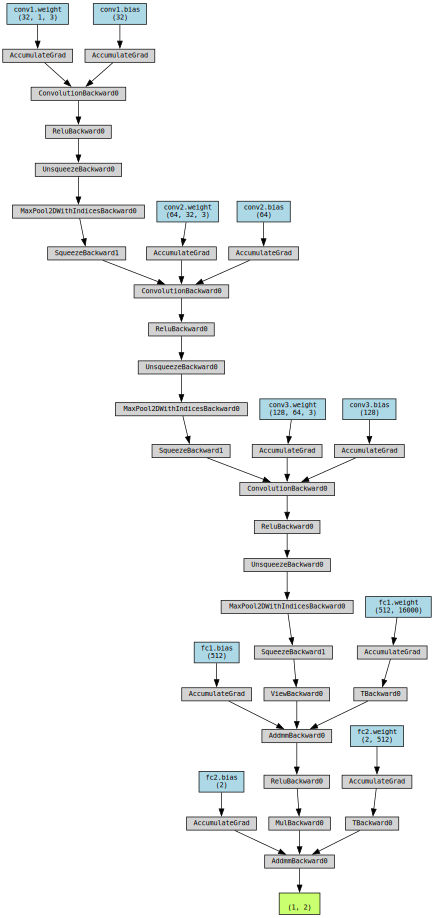

In [11]:
import torch
from torchviz import make_dot

model = SignalClassifierCNN() #initiate model

dummy_input = torch.randn(1, 1, 1000) #create dummy input

graph = make_dot(model(dummy_input), params=dict(model.named_parameters())) #generate graph

graph #display graph

### Compilation and Training
---

In [12]:
def train_model(model, load_train, load_val, criterion, optimiser, num_epochs):
    """
    Trains a neural network model and evaluates its performance on both training and validation datasets.

    During each epoch, the model is trained on the training dataset and evaluated on the validation dataset. 
    The function tracks and returns the history of loss and accuracy for both datasets.

    Parameters:
    model (nn.Module): The neural network model to be trained.
    load_train (DataLoader): DataLoader for the training dataset.
    load_val (DataLoader): DataLoader for the validation dataset.
    criterion: The loss function used for training.
    optimiser: The optimisation algorithm used for training.
    num_epochs (int): The number of epochs to train the model.

    Returns:
    dict: A dictionary containing the training and validation loss and accuracy for each epoch.
    """
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        #set model to training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in load_train:
            optimiser.zero_grad() #reset gradients
            outputs = model(inputs) #forward pass
            loss = criterion(outputs, labels) #calculate loss
            loss.backward() #backpropogation
            optimiser.step() #optimise

            #update training loss and accuracy counts
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        #compute and store average training loss and accuracy
        train_accuracy = train_correct / train_total
        history['train_loss'].append(train_loss / len(load_train))
        history['train_accuracy'].append(train_accuracy)

        #evaluation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad(): #disabling gradient calculation
            for inputs, labels in load_val:
                outputs = model(inputs) #forward pass
                loss = criterion(outputs, labels) #calculate loss

                #update counts
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        #compute and store average validation loss and accuracy
        val_accuracy = val_correct / val_total
        history['val_loss'].append(val_loss / len(load_val))
        history['val_accuracy'].append(val_accuracy)

        #print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {history["train_loss"][-1]:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {history["val_loss"][-1]:.4f}, '
              f'Val Accuracy: {val_accuracy:.4f}')

    return history

**Loss Function: 'nn.CrossEntropyLoss()'**

- This function combines softmax activation with a cross-entropy loss, which is commonly used for classification tasks.

**Optimiser: 'torch.optim.Adam'**

- The Adam optimiser is known for its efficiency. It is an adaptive learning rate optimiser that combines the advantages of two other extensions of stochastic gradient descent, namely AdaGrad and RMSProp.

**Learning Rate: 0.001**

- Dictates the step size during gradient descent. A value of 0.001 balances the need for quick convergence with the risk of overshooting the minimum.

**Number of Epochs: 50**

- Represents the full cycle through the training dataset. Will process through the entire dataset 50 times.

**Batch Size: 256**

- Determines number of training samples to work through before the model's internal parameters are updated.

### Design Rationale

**Loss Function** - Cross-entropy loss is effective for classification problems as it penalises incorrect classifications more heavily, encouraging the model to output probabilities closer to the actual labels.

**Optimiser** - Adam is chosen for its efficiency and adaptability. It automatically adjusts the learning rate during training, which often leads to better performance and faster convergence.

**Learning Rate** - A learning rate of 0.001 is a standard starting point that usually works well in practice with the Adam optimizer. It’s small enough to avoid diverging but large enough to ensure relatively fast convergence.

**Number of Epochs** - Training for 50 epochs is a balance between ensuring sufficient exposure to the entire dataset (for learning the underlying patterns) and avoiding excessive training time or overfitting.

**Batch Size** - A batch size of 256 is a compromise between computational efficiency and memory usage.

In [13]:
#model initilisation and parameter setting
model = SignalClassifierCNN()
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

#execute training
history = train_model(model, load_train, load_test, criterion, optimiser, num_epochs)

Epoch [1/50], Train Loss: 0.1575, Train Accuracy: 0.9434, Val Loss: 0.0645, Val Accuracy: 0.9782
Epoch [2/50], Train Loss: 0.0723, Train Accuracy: 0.9794, Val Loss: 0.0597, Val Accuracy: 0.9795
Epoch [3/50], Train Loss: 0.0603, Train Accuracy: 0.9821, Val Loss: 0.0477, Val Accuracy: 0.9841
Epoch [4/50], Train Loss: 0.0524, Train Accuracy: 0.9832, Val Loss: 0.0476, Val Accuracy: 0.9824
Epoch [5/50], Train Loss: 0.0512, Train Accuracy: 0.9841, Val Loss: 0.0457, Val Accuracy: 0.9837
Epoch [6/50], Train Loss: 0.0517, Train Accuracy: 0.9837, Val Loss: 0.0514, Val Accuracy: 0.9831
Epoch [7/50], Train Loss: 0.0434, Train Accuracy: 0.9857, Val Loss: 0.0470, Val Accuracy: 0.9824
Epoch [8/50], Train Loss: 0.0418, Train Accuracy: 0.9871, Val Loss: 0.0493, Val Accuracy: 0.9805
Epoch [9/50], Train Loss: 0.0383, Train Accuracy: 0.9880, Val Loss: 0.0508, Val Accuracy: 0.9834
Epoch [10/50], Train Loss: 0.0408, Train Accuracy: 0.9875, Val Loss: 0.0473, Val Accuracy: 0.9828
Epoch [11/50], Train Loss: 0.

In [14]:
import matplotlib.pyplot as plt

def learning_curve(history):
    """
    Plots the learning curves for loss and accuracy based on the training history.

    This function creates side-by-side plots of the training and validation loss, and the training and validation accuracy, across epochs.

    Parameters:
    history (dict): Contains 'train_loss', 'val_loss', 'train_accuracy', and 'val_accuracy'.
    num_epochs (int): Total number of epochs for which the model was trained.

    Returns:
    None: This function only plots the learning curves.
    """
    #define range of epochs
    epochs = range(1, num_epochs + 1)

    #setup plot dimensions and styles
    plt.figure(figsize=(12, 5))
    lw = 2 #line width


    #plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss', color = 'navy', lw = lw)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color = 'gold', lw = lw)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    #plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Training Accuracy', color = 'navy', lw = lw)
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', color = 'gold', lw = lw)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    #adjust layout and display
    plt.tight_layout()
    plt.show()

The loss quickly decreases, suggesting the model learns effectively. There are no signs of increasing loss over time, which suggests there is no overfitting to the training data. The loss increases substantially over time, with there being a significant gap between training and validation. This could potentially suggest overfitting

The accuracy increases sharply at the beginning and continues to do so at a lower rate. The model reaches a very high accuracy, suggesting it to be highly effective. The training accuracy plateaus, suggesting the model isn't learning much at later epochs. The validation seems to stay at a similar relative distance to the training accuracy, suggesting there isn't much improvement in generalisation with each epoch.

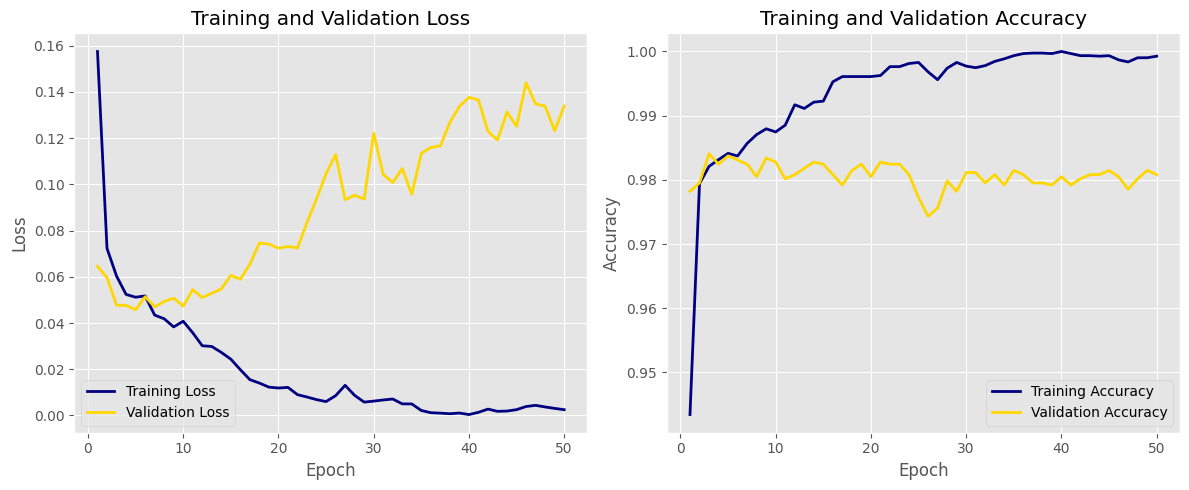

In [15]:
learning_curve(history)

### Making Predictions
---

In [16]:
def predict(model, data_loader):
    """
    Performs predictions using a trained model on a given dataset.

    This function goes through the data in the provided DataLoader, 
    performing predictions with the model and gathering the labels, 
    predictions, predicted probabilities, and features from the 
    last layer before the output layer.

    Parameters:
    model (nn.Module): The trained neural network model used for prediction.
    data_loader (DataLoader): DataLoader containing the dataset for prediction.

    Returns:
    tuple: A tuple containing four NumPy arrays:
           - all_labels: Actual labels of the data.
           - all_predictions: Predicted labels by the model.
           - all_probabilities: Predicted probabilities for the positive class.
           - all_features: Extracted features from the last layer before the output layer.
    """
    model.eval() #set model to evaluation mode

    #init blank arrays for storing model predictions
    all_labels = []
    all_predictions = []
    all_probabilities = []
    all_features = []

    with torch.no_grad(): #disable gradient calcs
        for inputs, labels in data_loader:
            features = model.forward_features(inputs) #extract features for analysis
            outputs = model(inputs) #generate outputs
            probabilities = F.softmax(outputs, dim=1)[:, 1] #compute probabilities

            _, predicted = torch.max(outputs.data, 1) #get class with highest probability as prediction

            #append to lists
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_features.extend(features.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities), np.array(all_features)

In [17]:
labels, pred, prob, features = predict(model, load_test)

### Initial Analysis
---

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc as compute_auc

def plot_roc_curve(labels, probabilities):
    """
    Plots the Receiver Operating Characteristic (ROC) curve and calculates the Area Under the Curve (AUC).

    This function takes true labels and predicted probabilities for the positive class to plot the ROC curve. 
    It also calculates and displays the AUC value, which is a measure of the model's performance.

    Parameters:
    labels (array): An array of true labels of the data.
    probabilities (array): An array of predicted probabilities for the positive class.

    Returns:
    None: This function only plots the ROC curve.
    """
    #calculate the false positive and true positive rates for various thresholds rates
    fpr, tpr, _ = roc_curve(labels, probabilities)
    roc_auc = compute_auc(fpr, tpr) #compute AUC

    #setup figure
    plt.figure(figsize=(8, 4))
    lw = 2 #line width

    #plot ROC curve and diagonal line for reference
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.6f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

The initial model gives a very strong AUC of over 0.99. This is beyond what was initially expected of a developed model and suggests the model is highly effective at differentiating between classes.

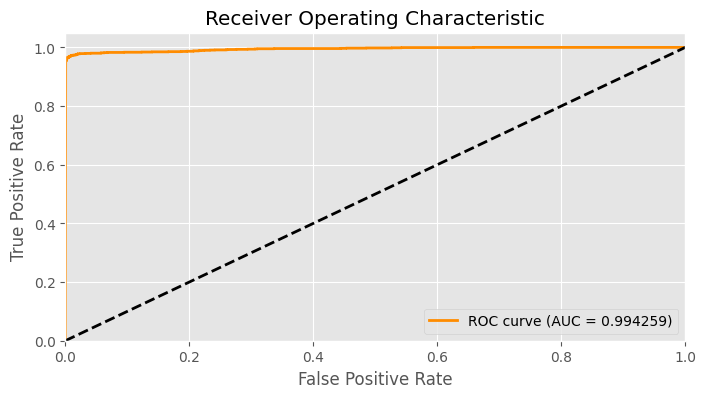

In [19]:
plot_roc_curve(labels, prob)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Accuracy was discussed with training, but calculating the value based on final predictions gives a result of 98.11% accuracy. Suggesting the algorithm is highly effective at discriminating signals.

In [21]:
acc = accuracy_score(labels,pred) #calc accuracy score
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9808


Additional metric can also be used to evaluate the performance of the model. 

The high precision score indicates the model has a low false positive rate. When it predicts a positive result, it is very likely to be correct.

In [22]:
prec = precision_score(labels,pred) #calc precision
print(f"Precision: {prec:.6f}")

Precision: 0.989226


Recall measures the model's ability to detect positive instances. Here NS has been chosen as the positive case, with the recall value indicating that is correctly identifies 97.22% of these instances.

In [23]:
rec = recall_score(labels,pred) #calc recall
print(f"Recall Score: {rec:.6f}")

Recall Score: 0.971561


The F1 score is the balance between precision and recall. Taking both false negatives and positives into account. This suggests that the model does not prioritise one other the other.

In [24]:
f1 = f1_score(labels,pred) #calc f1 score
print(f"f1 Score: {f1:.6f}")

f1 Score: 0.980314


A t-SNE gives a 2D visual representation of the features used in distinguishing classes. This can give valuable insight into the model and how effectively it is able to separate classes.

In [25]:
from sklearn.manifold import TSNE

def tsne(features, labels, probabilities):
    """
    Visualises high-dimensional data using t-SNE (t-distributed Stochastic Neighbor Embedding) based on extracted features.

    This function reduces the dimensionality of the feature space to 2D for visualisation purposes. It plots the t-SNE results, 
    coloring data points according to their true labels. This visualisation helps in understanding the separability of classes in 
    the feature space.

    Parameters:
    features (np.array): Extracted features from the model, expected to be of high dimension.
    labels (np.array): True binary labels of the data.
    probabilities (np.array): Probabilities of the positive class.

    Returns:
    None: The function only creates a plot.
    """
    #reduce dimensions to 2
    tsne = TSNE(n_components=2, random_state=123)
    tsne_results = tsne.fit_transform(features)

    #setup the plot
    plt.figure(figsize=(8, 7))

    #plot data points with different colours based on classes
    plt.scatter(tsne_results[labels == 0, 0], tsne_results[labels == 0, 1], color='xkcd:darkblue', label='ES Signal', alpha = 0.7)
    plt.scatter(tsne_results[labels == 1, 0], tsne_results[labels == 1, 1], color='xkcd:dark red', label='NS Signal', alpha = 0.7)

    #add labels and titles
    plt.legend()
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE Visualisation of Signal Features')
    plt.show()

The model is effective as distinguishing between classes, as demonstrated by the limited mixing between the two signals.

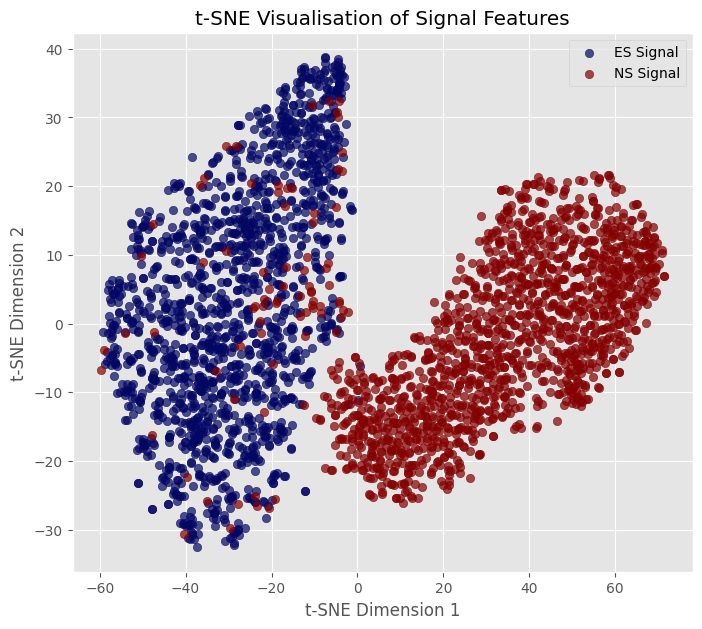

In [26]:
tsne(features, labels, prob)

The model and cache can be cleared before starting with any new models.

In [27]:
del model
del optimiser
import gc
gc.collect()
torch.cuda.empty_cache()

# Exploring Previous Studies
---

It's worth reviewing past literature to understand similar approaches used in PSD studies involving the application of CNNs, this may lead to an improved model. There have been various studies and CNNs seem to be a common approach in PSD, however this paper will focus mostly on Griffith's and Jung's work to explore CNN designs.

## Griffith's Model
---

Griffiths et al (2020) demonstrate the application of various algorithms in the PSD of ES and NS signals, finding CNNs to lead to the highest area under curve (AUC). The CNN architecture and hyperparameters used within their study are also detailed. Their study will be modelled and discussed before being compared to other methods used in PSD.

### CNN Architecture
---

In [28]:
class gSignalClassifierCNN(nn.Module):
    """
    A Convolutional Neural Network (CNN) for classifying signals.

    This network consists of two convolutional layers, each followed by max-pooling,
    and two fully connected (dense) layers. Designed for binary classification
    tasks (e.g., distinguishing between two types of signals).

    Attributes:
    conv1 (nn.Conv1d): The first convolutional layer.
    pool1 (nn.MaxPool1d): The first max-pooling layer.
    conv2 (nn.Conv1d): The second convolutional layer.
    pool2 (nn.MaxPool1d): The second max-pooling layer.
    fc1 (nn.Linear): The first fully connected layer.
    fc2 (nn.Linear): The second fully connected layer (output layer).
    dropout (nn.Dropout): Dropout layer for regularization.
    """
    def __init__(self):
        super(gSignalClassifierCNN, self).__init__()
        
        #first convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=7, kernel_size=10, stride=1, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        #cecond convolutional layer
        self.conv2 = nn.Conv1d(in_channels=7, out_channels=14, kernel_size=10, stride=1, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        #calc the size of the flattened features after the second pooling layer
        flattened_size = 14 * ((1000 - 9) // 2 - 9) // 2

        #fully connected layer
        self.fc1 = nn.Linear(flattened_size, 64)

        #output layer
        self.fc2 = nn.Linear(64, 2)
        
        #dropout layer - for regularisation
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Parameters:
        x (Tensor): Input tensor of shape (batch_size, channels, signal_length).

        Returns:
        Tensor: Output tensor after passing through the network.
        """
        #apply 1st/2nd convulational layers followed by ReLU and max pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        #flatten tensor
        x = x.view(x.size(0), -1)

        #apply first fully connected layer
        x = F.relu(self.fc1(x))
        #apply dropout for regularisation
        x = self.dropout(x)
        #output layer
        x = self.fc2(x)
    
        return x

    def forward_features(self, x):
        """
        Extracts features from the last layer before the output layer.

        This method can be used for feature visualization or for transfer learning.

        Parameters:
        x (Tensor): Input tensor of shape (batch_size, channels, signal_length).

        Returns:
        Tensor: Features extracted from the last fully connected layer.
        """
        #process through convolutional and pooling layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        #flatten and pass through the first fully connected layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        
        return x

**Convolutional and Pooling Layers:**
- The CNN includes two successive convolution and pooling layers.
- The first convolutional layer has 7 channels with a filter size of 10.
- The first max-pooling layer follows with a window size of 2.
- The second convolutional layer has 14 channels with a filter size of 10.
- The second max-pooling layer again has a window size of 2.
- Activation Function: The ReLU (Rectified Linear Unit) activation function is used in both convolutional layers.
- Fully Connected Layer: After the convolutional and pooling layers, the feature maps are fed into a fully-connected layer with 64 neurons, also using the ReLU activation - function.
- Output Layer: The output of the CNN is a single neuron with softmax activation, which represents the probability of a signal being NS (Nuclear Scintillation).

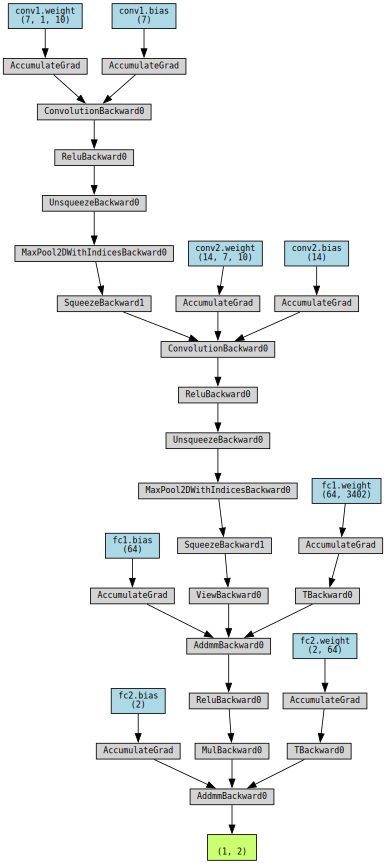

In [29]:
model = gSignalClassifierCNN() #initiate model

dummy_input = torch.randn(1, 1, 1000) #create dummy input

graph = make_dot(model(dummy_input), params=dict(model.named_parameters())) #generate graph

graph #display graph

### Compilation and Training 
---

**Training Details:**

- The network is trained using the Adam optimizer with a binary cross-entropy loss function.
- The training is conducted for 50 epochs with a batch size of 256 samples.
- The initial learning rate is set to 0.001.
- An equal proportion of ES and NS signals are used in the training sample.

In [30]:
#model initiliation and parameter setting
model = gSignalClassifierCNN()
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

#execute training
history = train_model(model, load_train, load_test, criterion, optimiser, num_epochs)

Epoch [1/50], Train Loss: 0.2291, Train Accuracy: 0.9265, Val Loss: 0.0695, Val Accuracy: 0.9785
Epoch [2/50], Train Loss: 0.0841, Train Accuracy: 0.9752, Val Loss: 0.0630, Val Accuracy: 0.9792
Epoch [3/50], Train Loss: 0.0760, Train Accuracy: 0.9778, Val Loss: 0.0596, Val Accuracy: 0.9808
Epoch [4/50], Train Loss: 0.0741, Train Accuracy: 0.9786, Val Loss: 0.0510, Val Accuracy: 0.9815
Epoch [5/50], Train Loss: 0.0638, Train Accuracy: 0.9813, Val Loss: 0.0492, Val Accuracy: 0.9824
Epoch [6/50], Train Loss: 0.0613, Train Accuracy: 0.9821, Val Loss: 0.0480, Val Accuracy: 0.9841
Epoch [7/50], Train Loss: 0.0630, Train Accuracy: 0.9803, Val Loss: 0.0582, Val Accuracy: 0.9776
Epoch [8/50], Train Loss: 0.0566, Train Accuracy: 0.9840, Val Loss: 0.0492, Val Accuracy: 0.9844
Epoch [9/50], Train Loss: 0.0539, Train Accuracy: 0.9838, Val Loss: 0.0472, Val Accuracy: 0.9808
Epoch [10/50], Train Loss: 0.0530, Train Accuracy: 0.9839, Val Loss: 0.0539, Val Accuracy: 0.9782
Epoch [11/50], Train Loss: 0.

The loss starts high and quickly decreases, suggesting the model learns effectively. There are no signs of increasing loss over time, which suggests there is no overfitting to the training data. The validation loss starts at a similar value to the training loss, suggesting the model initially generalises well to unseen data. It does seem to increase towards the end, however it is not so pronounced. This could suggest some overfitting.

The accuracy increases sharply at the beginning and continues to do so at a lower rate. The model reaches near 100% accuracy, suggesting it to be highly effective. The validation accuracy plateaus and fluctuates at later epochs, suggesting that the model performs well on training data but doesn't seem much improvement in terms of generalisation after a certain point.

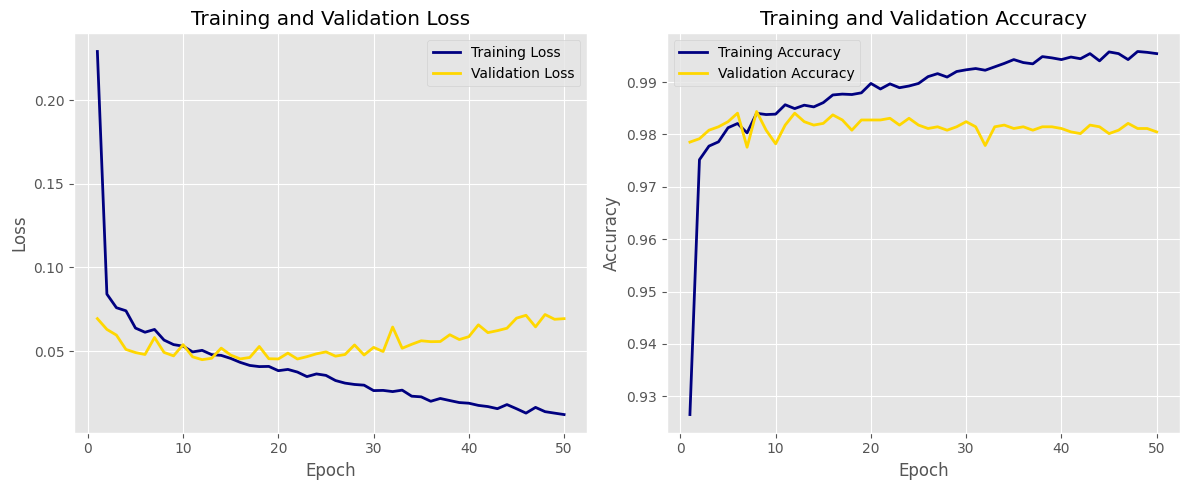

In [31]:
learning_curve(history)

### Evaluation 
---

In [32]:
glabels, gpred, gprob, gfeatures = predict(model, load_test)

Griffith's model achieves an AUC of 0.997 (3 sf), indicating the model is highly effective at classifying positive cases whilst also minimising false positives. This is also supported by the curve which clings closely to the y-axis.

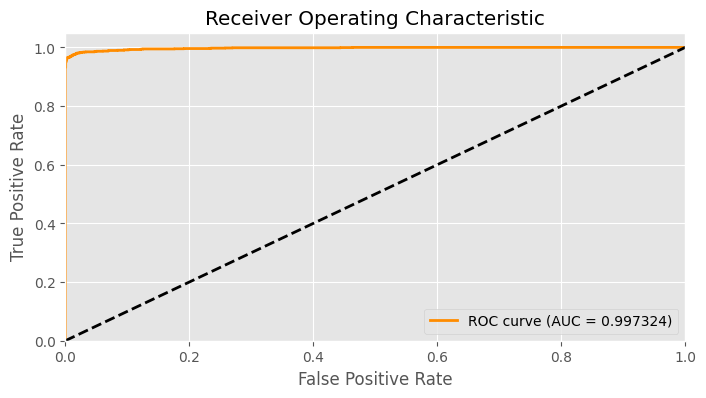

In [33]:
plot_roc_curve(glabels, gprob)

From the visualisation, there is clear clustering of the two classes. These two clusters don't seem to particularly overlap, however there are some outliers. This suggests that the model is generally effective at distinguishing classes.

In [34]:
prec = precision_score(glabels,gpred) #calc precision
print(f"Precision: {prec:.6f}")
rec = recall_score(glabels,gpred) #calc recall
print(f"Recall Score: {rec:.6f}")
f1 = f1_score(glabels,gpred) #calc f1 score
print(f"f1 Score: {f1:.6f}")

Precision: 0.985294
Recall Score: 0.974868
f1 Score: 0.980053


Similarly, the t-SNE demonstrates that the feature generated are effective at distinguishing between ES and NS signals.

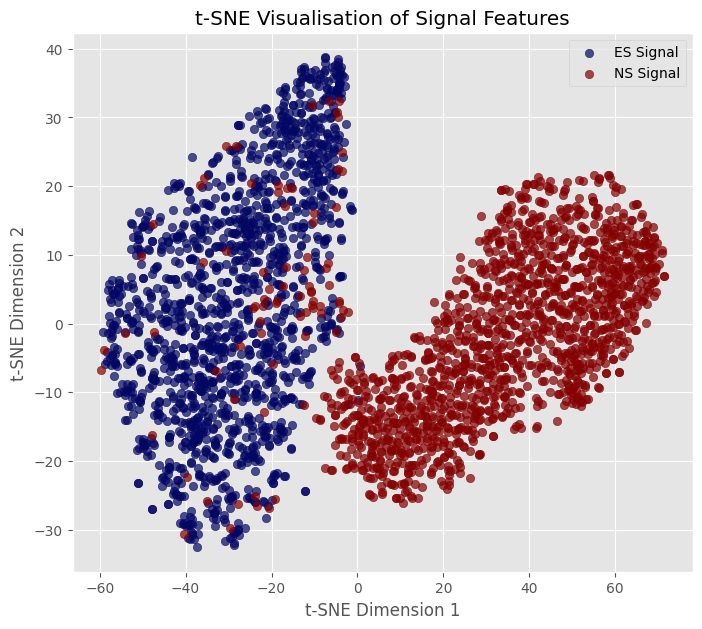

In [35]:
tsne(features, labels, prob)

## Jung's Model
---

In their 2023 study, Jung et al demonstrate the capability of a CNN to discriminate low-energy electron recoil (β/γ) from proton recoil (α/fast-n) events. The methodology, architecture and training parameters used in the study can be summarised as follows:

- Magnitude of fast Fourier transform (FFT) signals with 98 data points as input.
- First convolutional layer with 16 kernels, size three, stride of 3, and ReLU activation.
- Second convolutional layer with 32 kernels, size two, stride of 2, and ReLU activation.
- Max pooling applied in the second convolutional layer to reduce feature map size and prevent overfitting.
- Dropout after each convolutional layer to improve generalisation and avoid overfitting.
- Binary cross-entropy as the loss function and Adam optimiser for training.

The general architecture and training parameters used share many similarities with Griffith's study, however a key difference is the application of a Fourier transform on the data. Jung's study also used much fewer datapoints, with the distinctions in architecture used during this study likely coming as a result of this.

To evaluate solely the effect of a FFT on CNN performance, FFT signals will be used with the same architecture used previously.

In [36]:
mX_train = xtrain_magnitude.reshape(xtrain_magnitude.shape[0], 1, xtrain_magnitude.shape[1]) #adds number of channels to make required input
mX_test = xtest_magnitude.reshape(xtest_magnitude.shape[0], 1, xtest_magnitude.shape[1]) #adds number of channels to make required input

load_train, load_test = load_data(mX_train,mX_test, mty_train, mty_test)

In [37]:
history = train_model(model, load_train, load_test, criterion, optimiser, num_epochs)

Epoch [1/50], Train Loss: 0.9386, Train Accuracy: 0.8068, Val Loss: 0.3218, Val Accuracy: 0.8843
Epoch [2/50], Train Loss: 0.2565, Train Accuracy: 0.9065, Val Loss: 0.1436, Val Accuracy: 0.9447
Epoch [3/50], Train Loss: 0.1647, Train Accuracy: 0.9429, Val Loss: 0.1254, Val Accuracy: 0.9496
Epoch [4/50], Train Loss: 0.1437, Train Accuracy: 0.9495, Val Loss: 0.1207, Val Accuracy: 0.9486
Epoch [5/50], Train Loss: 0.1328, Train Accuracy: 0.9535, Val Loss: 0.1198, Val Accuracy: 0.9535
Epoch [6/50], Train Loss: 0.1262, Train Accuracy: 0.9540, Val Loss: 0.1149, Val Accuracy: 0.9577
Epoch [7/50], Train Loss: 0.1205, Train Accuracy: 0.9558, Val Loss: 0.1140, Val Accuracy: 0.9532
Epoch [8/50], Train Loss: 0.1171, Train Accuracy: 0.9587, Val Loss: 0.1153, Val Accuracy: 0.9522
Epoch [9/50], Train Loss: 0.1168, Train Accuracy: 0.9579, Val Loss: 0.1153, Val Accuracy: 0.9548
Epoch [10/50], Train Loss: 0.1121, Train Accuracy: 0.9588, Val Loss: 0.1156, Val Accuracy: 0.9564
Epoch [11/50], Train Loss: 0.

Both the training and validation loss decreases sharply with initial epochs, suggesting the model learns effecitvely. The loss continues but flattens out as it converges to optimisation. The validation stays close to the loss, indicating it generalises well to unseen data.

Both training and validation accuracy increase in early epochs and continue to do so. The accuracy doesn't seem to plateau as much as Griffith's model, although there is a higher difference between the validation and test. This suggests that although the model could improve further in accuracy with additional epochs, this would come at the cost of generalisation.

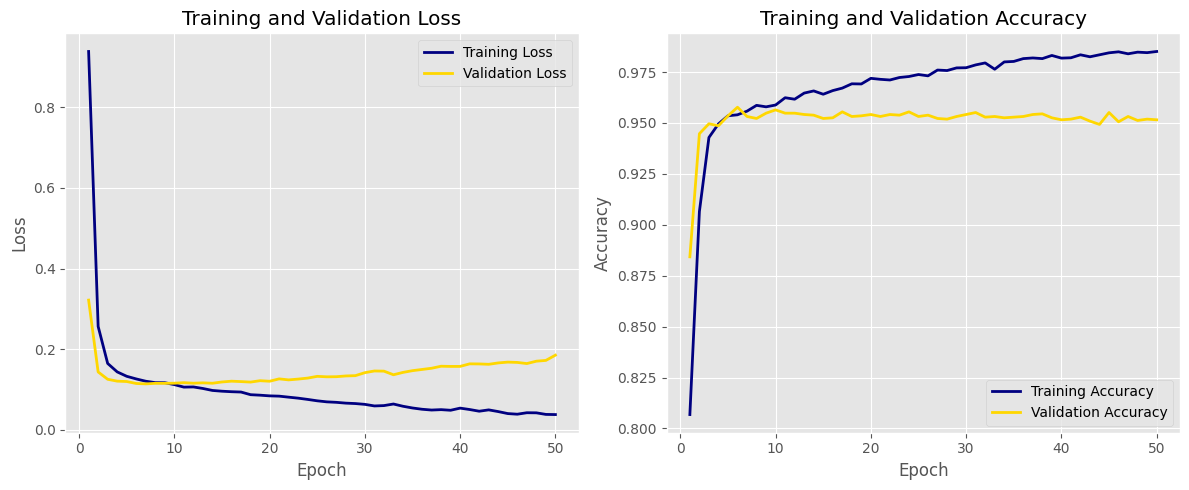

In [38]:
learning_curve(history)

In [39]:
flabels, fpred, fprob, ffeatures = predict(model, load_test)

This model still achieves a very strong AUC, however it performs slightly less effectively than the non-transformed model.

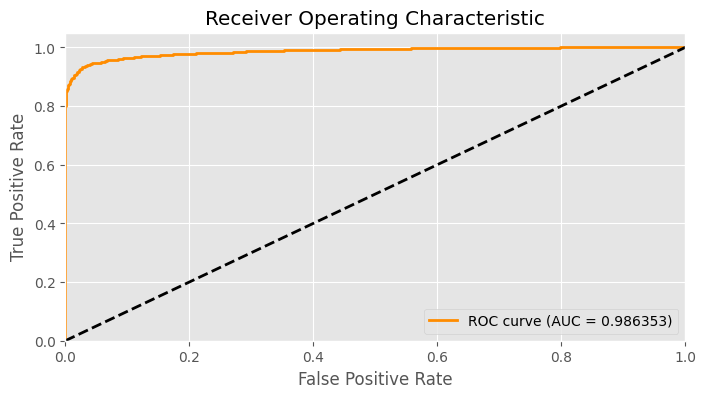

In [40]:
plot_roc_curve(flabels, fprob)

The model is somewhat less accurate than the non-Fourier model.

In [41]:
acc = accuracy_score(flabels,fpred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9516


This model achieves a decent balance between precision and recall.

In [42]:
prec = precision_score(flabels,fpred) #calc precision
print(f"Precision: {prec:.6f}")
rec = recall_score(flabels,fpred) #calc recall
print(f"Recall Score: {rec:.6f}")
f1 = f1_score(flabels,fpred) #calc f1 score
print(f"f1 Score: {f1:.6f}")

Precision: 0.963921
Recall Score: 0.936508
f1 Score: 0.950017


The model is effective at differentiating between the two classes using the features. This is shown by the clear clusters. However there is noticeably more mixing of the two classes.

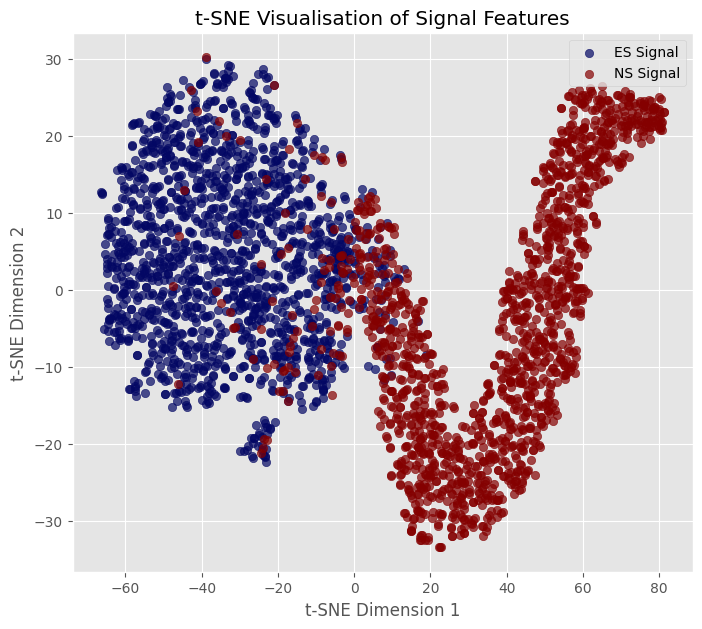

In [43]:
tsne(ffeatures, flabels, fprob)

In [44]:
del model
del optimiser
import gc
gc.collect()
torch.cuda.empty_cache()

## 2D CNN with Magnitude and Phase
---

In [45]:
#reshape phase data to add a channel dimension
pX_train = xtrain_phase.reshape(-1, 1, xtrain_phase.shape[1])
pX_test = xtest_phase.reshape(-1, 1, xtest_phase.shape[1])

#stack magnitude and phase along the channel dimension
combined_X_train = np.concatenate((mX_train, pX_train), axis=1)
combined_X_test = np.concatenate((mX_test, pX_test), axis=1)

#load into DataLoaders
load_train, load_test = load_data(combined_X_train, combined_X_test, mty_train, mty_test)

The architecture here is the same as with the Griffith's model, however adapted into a 2D Convolutional Neural Network.

In [46]:
class TwoDSignalClassifierCNN(nn.Module):
    def __init__(self):
        super(TwoDSignalClassifierCNN, self).__init__()
        # First convolutional layer, modified for two-channel input
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=7, kernel_size=10, stride=1, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        # Second convolutional layer
        self.conv2 = nn.Conv1d(in_channels=7, out_channels=14, kernel_size=10, stride=1, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # Calculate the size of the flattened features after the second pooling layer
        flattened_size = 14 * ((1000 - 9) // 2 - 9) // 2

        # Fully connected layer
        self.fc1 = nn.Linear(flattened_size, 64)

        # Output layer
        self.fc2 = nn.Linear(64, 2)  # Assuming binary classification
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)
    
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
    
        return x

    def forward_features(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return x

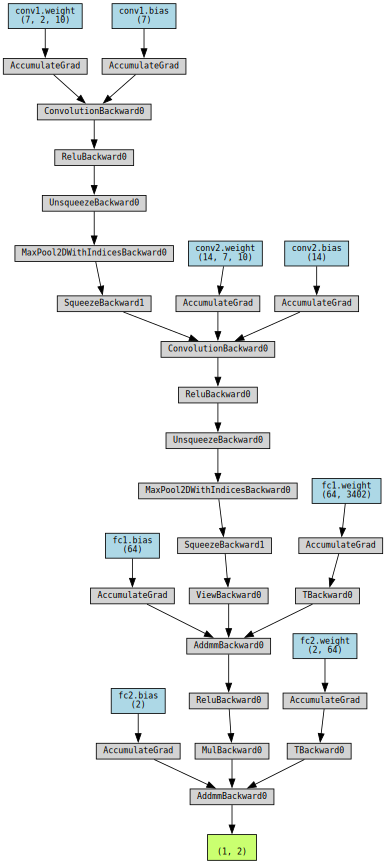

In [47]:
model = TwoDSignalClassifierCNN() #initiate model

dummy_input = torch.randn(1, 2, 1000) #create dummy input

graph = make_dot(model(dummy_input), params=dict(model.named_parameters())) #generate graph

graph #display graph

In [48]:
model = TwoDSignalClassifierCNN() #redefine model
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
history = train_model(model, load_train, load_test, criterion, optimiser, num_epochs)

Epoch [1/50], Train Loss: 0.3632, Train Accuracy: 0.8567, Val Loss: 0.1872, Val Accuracy: 0.9392
Epoch [2/50], Train Loss: 0.1796, Train Accuracy: 0.9361, Val Loss: 0.1490, Val Accuracy: 0.9470
Epoch [3/50], Train Loss: 0.1655, Train Accuracy: 0.9409, Val Loss: 0.1456, Val Accuracy: 0.9457
Epoch [4/50], Train Loss: 0.1512, Train Accuracy: 0.9460, Val Loss: 0.1356, Val Accuracy: 0.9516
Epoch [5/50], Train Loss: 0.1309, Train Accuracy: 0.9525, Val Loss: 0.1311, Val Accuracy: 0.9506
Epoch [6/50], Train Loss: 0.1217, Train Accuracy: 0.9578, Val Loss: 0.1443, Val Accuracy: 0.9558
Epoch [7/50], Train Loss: 0.1159, Train Accuracy: 0.9574, Val Loss: 0.1181, Val Accuracy: 0.9590
Epoch [8/50], Train Loss: 0.1057, Train Accuracy: 0.9625, Val Loss: 0.1203, Val Accuracy: 0.9555
Epoch [9/50], Train Loss: 0.0969, Train Accuracy: 0.9653, Val Loss: 0.1190, Val Accuracy: 0.9571
Epoch [10/50], Train Loss: 0.0876, Train Accuracy: 0.9685, Val Loss: 0.1367, Val Accuracy: 0.9594
Epoch [11/50], Train Loss: 0.

There seems to be a large gap between training and validation loss, indicating the model wouldn't fit well to unseen data. Both the accuracy and loss seem to plateau, indicating that the number of epochs is valid.

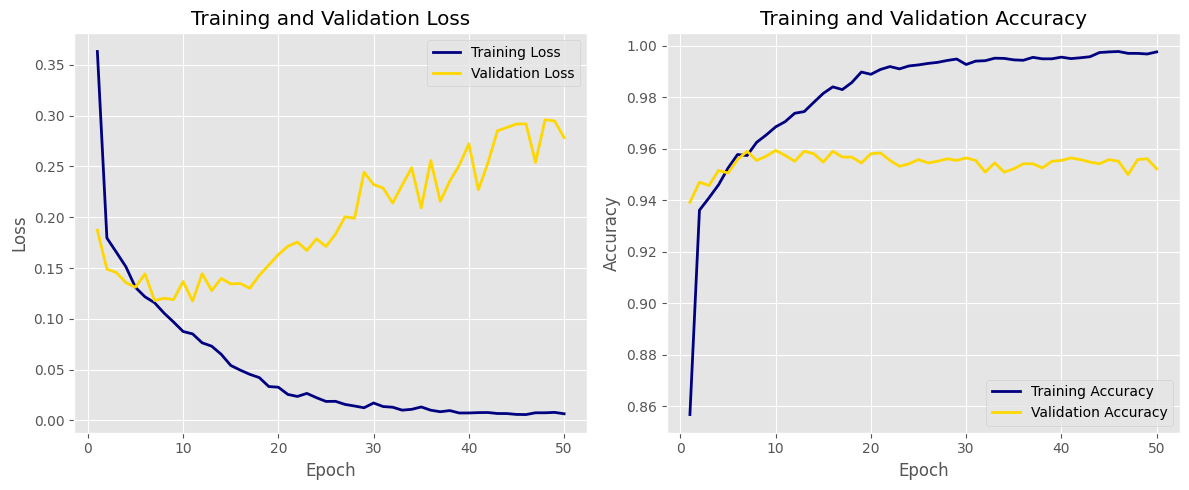

In [49]:
learning_curve(history)

In [50]:
plabels, ppred, pprob, pfeatures = predict(model, load_test)

An AUC of 0.986 is slightly better than the AUC without the inclusion of phase, however still performs worse than the non-Fourier model.

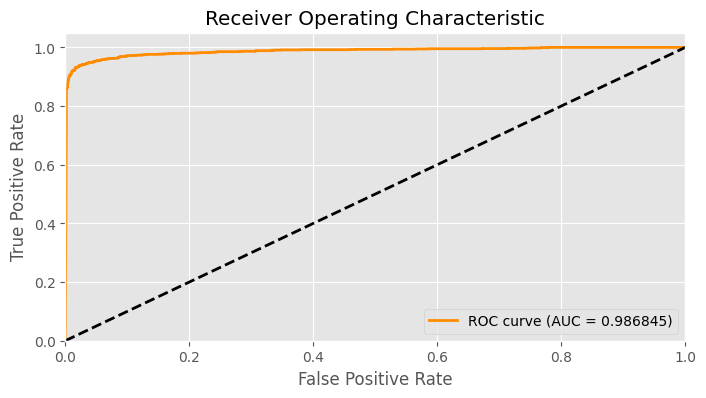

In [51]:
plot_roc_curve(plabels, pprob)

Similarly the accuracy is also slightly better, but still worse than the non-Fourier model.

In [52]:
acc = accuracy_score(plabels,ppred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9522


The model achieves a strong balance between precision and recall.

In [53]:
prec = precision_score(plabels,ppred) #calc precision
print(f"Precision: {prec:.6f}")
rec = recall_score(plabels,ppred) #calc recall
print(f"Recall Score: {rec:.6f}")
f1 = f1_score(plabels,ppred) #calc f1 score
print(f"f1 Score: {f1:.6f}")

Precision: 0.951688
Recall Score: 0.951058
f1 Score: 0.951373


There is still some mixing between ES and NS, indicating the model isn't perfect at distinguishing the two signals.

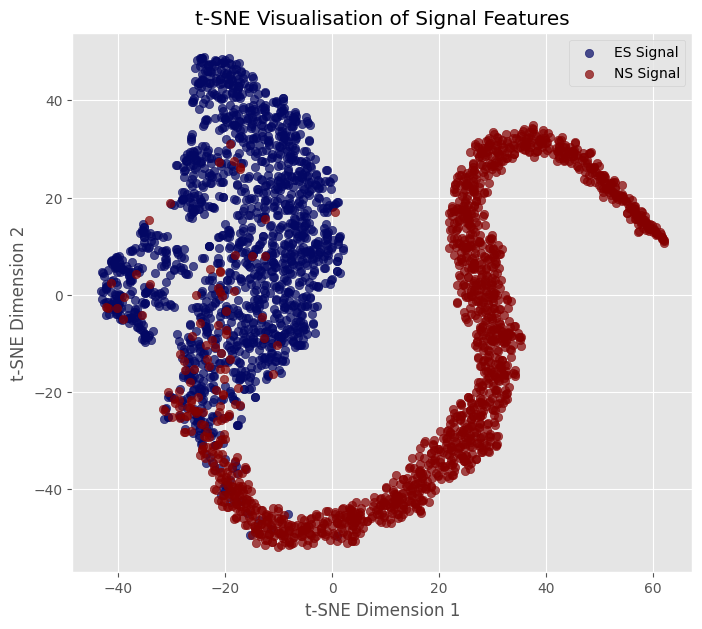

In [54]:
tsne(pfeatures, plabels, pprob)

## Discussion
---

Various different models were developed. The first of which being a deeper 1D CNN with three different layers. Beyond this various different studies were explored and their methodologies examined. This includes Griffith’s model and experimenting with FFTs from Jung’s study, both in a 1D and 2D CNN. Griffith’s model led to (marginally) the best value of AUC with the least over-fitting. The reasons behind this will now be examined in detail.

**Increasing Layers and Complexity**

Although there was a very limited difference between the AUC from the complex model and Griffith’s model, with the complex model taking significantly longer to train. This is due to the additional layers adding extra complexity. It seems that due to the limited difference, that the simpler model is able learn patterns in the data without the need for a large number of layers.

By increasing the number of layers there is an increased risk of over-fitting, which seems to have been the case with the more complex model. This is noticeable by looking at the validation curves on the training graphs. More complex models are able to learn more intricate patterns, but then they can become over-fit by learning the specific patterns of the training data.

**Further Tuning**

It’s possible that the more complex model could actually require further tuning, although it does perform amicably. The model used in Griffith’s study has likely been tuned much more, considering it is part of an academic research project. Filters in the more complex model could be tuned, with them likely being too high. Similarly the number of neurons in the fully connected layer could also be tuned. The drop-out level could also investigated as it may not be suitable for a model of this complexity.

**Fourier Tranform**

The Fourier transform converts time-domain signals into the frequency domain. This can highlight important frequency components, however it can obscure time-domain features. For certain signals, where the frequency more discriminating than the time-domain, this could prove to be quite valuable. However in this instance these temporal relationships are essential for accurate predictions.

Fourier transforms produce complex outputs representing both magnitude and phase. By only using magnitude data, a key piece of potentially discriminating data could be lost. A 2D CNN was developed that used both magnitude and phase, however it did not lead to better results than Griffith’s study. It’s possible that due to the increase in dimensions a deeper more complex CNN would lead to an improvement, however seems somewhat unlikely due to the other shortcomings of using a FFT. 

**Conclusion**

Various different models were tested and evaluated, including a deeper more complex model, a simpler model and models using FFTs, both with just magnitude and magnitude and phase. Griffith’s simpler model was found to be the most optimal, in particular in terms of generalisation and computational intensity. The more complex model performed with a similar AUC to Griffith’s model, suggesting that the patterns within the data aren’t intricate enough to require three layers. Fourier transforms could be a useful approach in certain situations that place emphasis on the frequency domain, however in this situation time-domain features were important in the model differentiating between signals. All models developed were effective in distinguishing between signals, however Griffith’s model provides the most optimal solution to this particular problem.




## Bibliography
---

Pulse shape discrimination and exploration of scintillation signals using convolutional neural networks, J Griffiths et al, 2020, Mach. Learn.: Sci. Technol. 1 045022

Pulse shape discrimination using a convolutional neural network for organic liquid scintillator signals, K.Y. Jung et al, 2023, JINST 18 P03003